In [1]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4111    0  4111    0     0  10481      0 --:--:-- --:--:-- --:--:-- 10487
100  517k  100  517k    0     0  89490      0  0:00:05  0:00:05 --:--:--  117k
--2025-06-21 21:29:21--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

In [2]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import talib # For technical indicators
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('GOOGLE.csv')

In [4]:
df

,Date,Open,High,Low,Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044
...,...,...,...,...,...,...
4712,2023-05-09,108.389999,110.150002,107.190002,107.349998,36360100
4713,2023-05-10,107.970001,112.940002,107.930000,111.750000,63153400
4714,2023-05-11,115.400002,117.919998,114.410004,116.570000,78900000
4715,2023-05-12,116.680000,118.029999,116.110001,117.510002,41073800


In [5]:
def handle_missing_values(df):
    """
    Handle missing values in the stock dataframe

    Parameters:
    df (pd.DataFrame): Raw stock data with potential missing values

    Returns:
    pd.DataFrame: Cleaned dataframe with missing values handled
    """
    print(f"Original data shape: {df.shape}")
    print(f"Missing values per column:\n{df.isnull().sum()}")

    df_cleaned = df.copy()

    if df_cleaned.isnull().sum().sum() > 0:
        print("Missing values detected. Handling...")


        df_cleaned = df_cleaned.fillna(method='ffill')

        df_cleaned = df_cleaned.dropna()

        print(f"After cleaning shape: {df_cleaned.shape}")
        print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")
    else:
        print("No missing values found.")

    return df_cleaned


In [6]:
def normalize_features(df):
    """
    Normalize stock price and volume features using min-max scaling

    Parameters:
    df (pd.DataFrame): Stock dataframe with numerical features

    Returns:
    pd.DataFrame: Dataframe with normalized features
    """
    df_normalized = df.copy()

    price_columns = ['Open', 'High', 'Low', 'Close']
    volume_columns = ['Volume']

    print("Normalizing features...")

    if all(col in df_normalized.columns for col in price_columns):
        price_data = df_normalized[price_columns]
        global_min = price_data.min().min()
        global_max = price_data.max().max()

        print(f"Price normalization range: [{global_min:.2f}, {global_max:.2f}]")

        for col in price_columns:
            df_normalized[col] = (df_normalized[col] - global_min) / (global_max - global_min)

    # Normalize volume separately
    if all(col in df_normalized.columns for col in volume_columns):
        for col in volume_columns:
            min_val = df_normalized[col].min()
            max_val = df_normalized[col].max()

            print(f"Volume normalization range: [{min_val:.0f}, {max_val:.0f}]")

            if max_val - min_val != 0:
                df_normalized[col] = (df_normalized[col] - min_val) / (max_val - min_val)
            else:
                df_normalized[col] = 0.0

    print("Feature normalization completed.")
    return df_normalized


In [7]:
def ensure_data_consistency(df):
    """
    Ensure data types are consistent and properly formatted for model training

    Parameters:
    df (pd.DataFrame): Stock dataframe

    Returns:
    pd.DataFrame: Dataframe with consistent data types
    """
    df_processed = df.copy()

    print("Ensuring data consistency...")

    if 'Date' in df_processed.columns:
        print("Converting Date column to datetime and setting as index...")
        df_processed['Date'] = pd.to_datetime(df_processed['Date'])
        df_processed.set_index('Date', inplace=True)
    elif not isinstance(df_processed.index, pd.DatetimeIndex):
        print("Index is not datetime. Consider setting a proper datetime index.")

    stock_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in stock_columns:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').astype('float64')

    # Remove any columns that might have been added accidentally
    valid_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df_processed = df_processed[[col for col in valid_columns if col in df_processed.columns]]

    print(f"Final data types:\n{df_processed.dtypes}")
    print(f"Data shape: {df_processed.shape}")

    return df_processed


In [8]:
def handle_outliers(df, method='robust_scaler'):
    """
    Handle outliers in stock data using robust scaling methods instead of removing them

    Parameters:
    df (pd.DataFrame): Stock dataframe
    method (str): Method for outlier handling ('robust_scaler', 'winsorize', 'clip')

    Returns:
    pd.DataFrame: Dataframe with outliers handled using robust methods
    """
    df_robust = df.copy()

    print(f"Handling outliers using {method} method...")
    print(f"Original data shape: {df_robust.shape}")

    # Select numeric columns for processing
    numeric_columns = df_robust.select_dtypes(include=['float64', 'int64']).columns

    if method == 'robust_scaler':
        # Use RobustScaler which uses median and IQR for scaling
        # Less sensitive to outliers compared to StandardScaler
        from sklearn.preprocessing import RobustScaler

        print("Applying RobustScaler transformation...")
        scaler = RobustScaler()

        # Store column names before transformation
        column_names = df_robust[numeric_columns].columns

        # Apply robust scaling
        scaled_data = scaler.fit_transform(df_robust[numeric_columns])

        # Replace the original columns with scaled data
        df_robust[column_names] = scaled_data

        print("RobustScaler applied successfully.")
        print("This method uses median and IQR, making it robust to outliers.")

    elif method == 'winsorize':
        # Winsorization: Cap extreme values at specified percentiles
        from scipy.stats import mstats

        print("Applying Winsorization (capping at 5th and 95th percentiles)...")

        for col in numeric_columns:
            original_outliers = len(df_robust[col][
                (df_robust[col] < df_robust[col].quantile(0.05)) |
                (df_robust[col] > df_robust[col].quantile(0.95))
            ])

            # Winsorize the column (cap at 5th and 95th percentiles)
            df_robust[col] = mstats.winsorize(df_robust[col], limits=[0.05, 0.05])

            print(f"Column {col}: {original_outliers} extreme values capped")

    elif method == 'clip':
        # Clipping: Cap values at IQR-based bounds
        print("Applying IQR-based clipping...")

        for col in numeric_columns:
            Q1 = df_robust[col].quantile(0.25)
            Q3 = df_robust[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Count outliers before clipping
            outliers_count = ((df_robust[col] < lower_bound) | (df_robust[col] > upper_bound)).sum()

            # Clip the values
            df_robust[col] = df_robust[col].clip(lower=lower_bound, upper=upper_bound)

            print(f"Column {col}: {outliers_count} values clipped to bounds [{lower_bound:.4f}, {upper_bound:.4f}]")

    # Display transformation summary
    print(f"Final data shape: {df_robust.shape}")
    print("\nOutlier handling completed. Data statistics after transformation:")
    print(df_robust[numeric_columns].describe())

    return df_robust


In [9]:
def validate_stock_data(df):
    """
    Validate stock data for common issues and inconsistencies

    Parameters:
    df (pd.DataFrame): Stock dataframe to validate

    Returns:
    pd.DataFrame: Validated and corrected dataframe
    """
    df_validated = df.copy()

    print("Validating stock data...")

    # Check for basic stock data rules
    if all(col in df_validated.columns for col in ['Open', 'High', 'Low', 'Close']):
        # High should be >= max(Open, Close)
        # Low should be <= min(Open, Close)

        # Count invalid high values
        invalid_high = (df_validated['High'] < df_validated[['Open', 'Close']].max(axis=1)).sum()
        print(f"Invalid high values (High < max(Open, Close)): {invalid_high}")

        # Count invalid low values
        invalid_low = (df_validated['Low'] > df_validated[['Open', 'Close']].min(axis=1)).sum()
        print(f"Invalid low values (Low > min(Open, Close)): {invalid_low}")

        # Fix invalid values by adjusting
        df_validated['High'] = np.maximum(df_validated['High'],
                                        df_validated[['Open', 'Close']].max(axis=1))
        df_validated['Low'] = np.minimum(df_validated['Low'],
                                       df_validated[['Open', 'Close']].min(axis=1))

    # Check for negative values in price columns
    price_columns = ['Open', 'High', 'Low', 'Close']
    for col in price_columns:
        if col in df_validated.columns:
            negative_count = (df_validated[col] < 0).sum()
            if negative_count > 0:
                print(f"Warning: {negative_count} negative values found in {col}")
                # Remove rows with negative prices
                df_validated = df_validated[df_validated[col] >= 0]

    # Check for zero volume
    if 'Volume' in df_validated.columns:
        zero_volume = (df_validated['Volume'] == 0).sum()
        print(f"Zero volume days: {zero_volume}")

        # Option to remove zero volume days (uncomment if needed)
        # df_validated = df_validated[df_validated['Volume'] > 0]

    print(f"Validation completed. Final shape: {df_validated.shape}")
    return df_validated


In [10]:
def prepare_for_model_training(df):
    """
    Final preparation of data for model training

    Parameters:
    df (pd.DataFrame): Preprocessed stock dataframe

    Returns:
    pd.DataFrame: Model-ready dataframe
    """
    df_model_ready = df.copy()

    print("Preparing data for model training...")

    # Ensure chronological order
    if isinstance(df_model_ready.index, pd.DatetimeIndex):
        df_model_ready = df_model_ready.sort_index()
        print("Data sorted chronologically.")

    # Add basic validation
    print(f"Final data shape: {df_model_ready.shape}")
    print(f"Date range: {df_model_ready.index.min()} to {df_model_ready.index.max()}")
    print(f"Columns: {list(df_model_ready.columns)}")

    # Check for any remaining issues
    if df_model_ready.isnull().sum().sum() > 0:
        print("Warning: Missing values still present!")

    if (df_model_ready < 0).any().any():
        print("Warning: Negative values present!")

    # Final statistics
    print("\nFinal data statistics:")
    print(df_model_ready.describe())

    return df_model_ready


In [11]:
# Step 1: Handle missing values
df_cleaned = handle_missing_values(df)

# Step 2: Ensure data consistency
df_consistent = ensure_data_consistency(df_cleaned)

# Step 5: Normalize features
df_normalized = normalize_features(df_consistent)

# Step 6: Final preparation for model training
df_model_ready = prepare_for_model_training(df_normalized)

# Your preprocessed data is now ready for model training
print("Data preprocessing completed successfully!")


Original data shape: (4717, 6)
Missing values per column:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
No missing values found.
Ensuring data consistency...
Converting Date column to datetime and setting as index...
Final data types:
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object
Data shape: (4717, 5)
Normalizing features...
Price normalization range: [2.40, 151.55]
Volume normalization range: [9312000, 1643023332]
Feature normalization completed.
Preparing data for model training...
Data sorted chronologically.
Final data shape: (4717, 5)
Date range: 2004-08-19 00:00:00 to 2023-05-15 00:00:00
Columns: ['Open', 'High', 'Low', 'Close', 'Volume']

Final data statistics:
              Open         High          Low        Close       Volume
count  4717.000000  4717.000000  4717.000000  4717.000000  4717.000000
mean      0.245126     0.247851     0.242360     0.245169     0.069708
std       0.2

In [12]:
df_model_ready

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,0.000678,0.001359,0.000000,0.000735,0.541020
2004-08-20,0.000847,0.002201,0.000762,0.002072,0.273840
2004-08-23,0.002482,0.002940,0.002196,0.002255,0.217793
2004-08-24,0.002564,0.002624,0.001277,0.001495,0.180959
2004-08-25,0.001510,0.002020,0.001329,0.001685,0.106788
...,...,...,...,...,...
2023-05-09,0.710641,0.722441,0.702595,0.703668,0.016556
2023-05-10,0.707825,0.741148,0.707557,0.733169,0.032956
2023-05-11,0.757642,0.774538,0.751004,0.765487,0.042595


In [13]:
def extract_basic_features(data):
    """
    Extract basic stock information features
    """
    features = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    return features
features = extract_basic_features(df_model_ready)

In [14]:
def calculate_technical_indicators(data):
    """
    Calculate technical indicators for feature extraction
    """
    # Moving Average (MA)
    data['MA20'] = talib.SMA(data['Close'], timeperiod=20)

    # Moving Average Convergence Divergence (MACD)
    macd, macd_signal, macd_hist = talib.MACD(data['Close'],
                                             fastperiod=12,
                                             slowperiod=26,
                                             signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macd_signal
    data['MACD_Hist'] = macd_hist

    # KDJ
    data['K'], data['D'] = talib.STOCH(data['High'],
                                      data['Low'],
                                      data['Close'],
                                      fastk_period=9,
                                      slowk_period=3,
                                      slowk_matype=0,
                                      slowd_period=3,
                                      slowd_matype=0)
    data['J'] = 3 * data['K'] - 2 * data['D']

    # Relative Strength Index (RSI)
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14)

    # On Balance Volume (OBV)
    data['OBV'] = talib.OBV(data['Close'], data['Volume'])
    data['OBV'] = data['OBV'] / data['OBV'].max()  # Normalize

    # Bollinger Bands (BOLL)
    data['BOLL_Upper'], data['BOLL_Middle'], data['BOLL_Lower'] = talib.BBANDS(
        data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    return data

In [15]:
def merge_klines(data):
    print("Placeholder: Called merge_klines. Implement actual logic here.")
    # Return a placeholder or modified data structure if needed for subsequent functions
    return data.copy() # Returning a copy to avoid downstream errors

def identify_shapes(merged_klines):
    print("Placeholder: Called identify_shapes. Implement actual logic here.")
    # Return placeholder shapes or data
    return [], [] # Returning empty lists as placeholders

def connect_waves(bottom_shapes, top_shapes):
    print("Placeholder: Called connect_waves. Implement actual logic here.")
    # Return placeholder waves
    return [] # Returning empty list as a placeholder

def identify_trend_centers(waves):
    print("Placeholder: Called identify_trend_centers. Implement actual logic here.")
    # Return placeholder trend centers
    return pd.Series(index=waves[0].index if waves else pd.Index([])) # Returning empty series as placeholder

def score_price_position(close_prices, trend_centers):
    print("Placeholder: Called score_price_position. Implement actual logic here.")
    # Return a placeholder series
    # Ensure the returned series has the same index as close_prices
    return pd.Series(0.0, index=close_prices.index) # Returning a series of zeros as placeholder

def identify_hammer(data):
    print("Placeholder: Called identify_hammer. Implement actual logic here.")
    # Return a placeholder series (e.g., 0 or 1 indicating pattern presence)
    return pd.Series(0, index=data.index)

def identify_darkcloud_piercing(data):
    print("Placeholder: Called identify_darkcloud_piercing. Implement actual logic here.")
    # Return a placeholder series
    return pd.Series(0, index=data.index)

def identify_doji(data):
    print("Placeholder: Called identify_doji. Implement actual logic here.")
    # Return a placeholder series
    return pd.Series(0, index=data.index)

def identify_stars(data):
    print("Placeholder: Called identify_stars. Implement actual logic here.")
    # Return a placeholder series
    return pd.Series(0, index=data.index)

In [16]:
def extract_wave_features(data):
    """
    Extract wave theory features from stock data
    """
    # Create a copy of the data
    wave_data = data.copy()

    # K-line merge processing
    merged_klines = merge_klines(wave_data)

    # Identify bottom and top shapes
    bottom_shapes, top_shapes = identify_shapes(merged_klines)

    # Connect shapes to form waves
    waves = connect_waves(bottom_shapes, top_shapes)

    # Identify trend centers
    trend_centers = identify_trend_centers(waves)

    # Score the price position relative to trend centers
    wave_data['Wave_Score'] = score_price_position(wave_data['Close'], trend_centers)

    return wave_data


In [17]:
def extract_kline_patterns(data):
    """
    Extract K-line pattern features from stock data
    """
    pattern_data = data.copy()

    # Hammer and Hanging Man
    pattern_data['Hammer'] = identify_hammer(pattern_data)

    # Dark-Cloud Cover and Piercing Pattern
    pattern_data['DarkCloud_Piercing'] = identify_darkcloud_piercing(pattern_data)

    # Doji
    pattern_data['Doji'] = identify_doji(pattern_data)

    # Morning Star and Evening Star
    pattern_data['MorningStar_EveningStar'] = identify_stars(pattern_data)

    return pattern_data


In [18]:
df_featured = df_model_ready.copy()
df_featured = calculate_technical_indicators(df_featured)
df_featured = extract_wave_features(df_featured)
df_featured = extract_kline_patterns(df_featured)

Placeholder: Called merge_klines. Implement actual logic here.
Placeholder: Called identify_shapes. Implement actual logic here.
Placeholder: Called connect_waves. Implement actual logic here.
Placeholder: Called identify_trend_centers. Implement actual logic here.
Placeholder: Called score_price_position. Implement actual logic here.
Placeholder: Called identify_hammer. Implement actual logic here.
Placeholder: Called identify_darkcloud_piercing. Implement actual logic here.
Placeholder: Called identify_doji. Implement actual logic here.
Placeholder: Called identify_stars. Implement actual logic here.


In [19]:
df_featured

,Open,High,Low,Close,Volume,MA20,MACD,MACD_Signal,MACD_Hist,K,...,RSI,OBV,BOLL_Upper,BOLL_Middle,BOLL_Lower,Wave_Score,Hammer,DarkCloud_Piercing,Doji,MorningStar_EveningStar
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19,0.000678,0.001359,0.000000,0.000735,0.541020,NaN,NaN,NaN,NaN,NaN,...,NaN,0.029370,NaN,NaN,NaN,0.0,0,0,0,0
2004-08-20,0.000847,0.002201,0.000762,0.002072,0.273840,NaN,NaN,NaN,NaN,NaN,...,NaN,0.044235,NaN,NaN,NaN,0.0,0,0,0,0
2004-08-23,0.002482,0.002940,0.002196,0.002255,0.217793,NaN,NaN,NaN,NaN,NaN,...,NaN,0.056058,NaN,NaN,NaN,0.0,0,0,0,0
2004-08-24,0.002564,0.002624,0.001277,0.001495,0.180959,NaN,NaN,NaN,NaN,NaN,...,NaN,0.046235,NaN,NaN,NaN,0.0,0,0,0,0
2004-08-25,0.001510,0.002020,0.001329,0.001685,0.106788,NaN,NaN,NaN,NaN,NaN,...,NaN,0.052032,NaN,NaN,NaN,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09,0.710641,0.722441,0.702595,0.703668,0.016556,0.693966,0.007169,0.008046,-0.000876,66.135447,...,57.469643,0.883021,0.713319,0.693966,0.674613,0.0,0,0,0,0
2023-05-10,0.707825,0.741148,0.707557,0.733169,0.032956,0.696349,0.009648,0.008366,0.001282,78.098024,...,66.647066,0.884810,0.721743,0.696349,0.670955,0.0,0,0,0,0
2023-05-11,0.757642,0.774538,0.751004,0.765487,0.042595,0.699414,0.014057,0.009504,0.004553,78.415596,...,73.414765,0.887122,0.738796,0.699414,0.660031,0.0,0,0,0,0


In [20]:
df_featured.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
MA20,19
MACD,33
MACD_Signal,33
MACD_Hist,33
K,12


In [21]:
df_featured.dropna(inplace=True)
df_featured.sort_index(inplace=True)
df_featured

,Open,High,Low,Close,Volume,MA20,MACD,MACD_Signal,MACD_Hist,K,...,RSI,OBV,BOLL_Upper,BOLL_Middle,BOLL_Lower,Wave_Score,Hammer,DarkCloud_Piercing,Doji,MorningStar_EveningStar
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-06,0.006978,0.007129,0.006718,0.006900,0.158116,0.004161,0.001466,0.001179,0.000287,94.412820,...,77.222566,0.141605,0.007632,0.004161,0.000690,0.0,0,0,0,0
2004-10-07,0.006873,0.007369,0.006811,0.007197,0.167098,0.004468,0.001502,0.001244,0.000258,95.865481,...,78.397661,0.150676,0.007873,0.004468,0.001062,0.0,0,0,0,0
2004-10-08,0.007175,0.007336,0.006889,0.007009,0.129814,0.004740,0.001498,0.001295,0.000204,92.469969,...,75.735171,0.143629,0.008044,0.004740,0.001436,0.0,0,0,0,0
2004-10-11,0.006886,0.007198,0.006358,0.006594,0.122500,0.004973,0.001445,0.001325,0.000120,83.519503,...,70.082426,0.136979,0.008105,0.004973,0.001840,0.0,0,0,0,0
2004-10-12,0.006457,0.006988,0.006282,0.006953,0.137110,0.005190,0.001416,0.001343,0.000073,77.545519,...,72.030235,0.144422,0.008238,0.005190,0.002142,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09,0.710641,0.722441,0.702595,0.703668,0.016556,0.693966,0.007169,0.008046,-0.000876,66.135447,...,57.469643,0.883021,0.713319,0.693966,0.674613,0.0,0,0,0,0
2023-05-10,0.707825,0.741148,0.707557,0.733169,0.032956,0.696349,0.009648,0.008366,0.001282,78.098024,...,66.647066,0.884810,0.721743,0.696349,0.670955,0.0,0,0,0,0
2023-05-11,0.757642,0.774538,0.751004,0.765487,0.042595,0.699414,0.014057,0.009504,0.004553,78.415596,...,73.414765,0.887122,0.738796,0.699414,0.660031,0.0,0,0,0,0


In [22]:
#df_featured.drop(columns=["Wave_Score",	"Hammer",	"DarkCloud_Piercing",	"Doji",	"MorningStar_EveningStar"],axis=1,inplace = True)

In [23]:
df_featured.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'K', 'D', 'J', 'RSI', 'OBV', 'BOLL_Upper', 'BOLL_Middle',
       'BOLL_Lower', 'Wave_Score', 'Hammer', 'DarkCloud_Piercing', 'Doji',
       'MorningStar_EveningStar'],
      dtype='object')

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback

# ─────────────────────────────────────────
# 1.  Robust univariate LSTM architecture
# ─────────────────────────────────────────
def build_proper_lstm_model(input_shape=(20, 1)):
    """
    Deeper, regularised LSTM for Close-price prediction
    ---------------------------------------------------
    Layer stack
      • LSTM(100)  return_sequences=True
      • LSTM(50)
      • Dense(25)  ReLU
      • Dropout(0.2)
      • Dense(1)   linear
    """
    model = Sequential([
        LSTM(100, input_shape=input_shape,
             return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        LSTM(50, dropout=0.2, recurrent_dropout=0.2),
        Dense(25, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(1e-3), loss='mse')
    return model


# ─────────────────────────────────────────
# 2.  Build (X,y) sequences from Close
# ─────────────────────────────────────────
def make_sequences(close_array, win=20):
    X, y = [], []
    for i in range(len(close_array) - win):
        X.append(close_array[i:i + win])
        y.append(close_array[i + win])
    X = np.array(X).reshape(-1, win, 1)
    return X, np.array(y)


# ─────────────────────────────────────────
# 3.  Paper’s weighted 3-day return
# ─────────────────────────────────────────
def weighted_3day(prices):
    p = prices
    r1 = 0.4  * (p[1:] - p[:-1])     / p[:-1]
    r2 = 0.32 * (p[2:] - p[1:-1])    / p[1:-1]
    r3 = 0.28 * (p[3:] - p[2:-1])    / p[2:-1]
    out = r1[:-2] + r2[:-1] + r3
    return out            # length = len(prices) - 3


# ─────────────────────────────────────────
# 4.  Train + predict with live epoch log
# ─────────────────────────────────────────
def train_and_predict_verbose(df_scaled, win=20, epochs=50, batch=32):
    """
    • Univariate LSTM fit on scaled Close
    • Shows epoch-by-epoch loss while training
    • Returns true & predicted 3-day returns (aligned)
    """
    close_vals = df_scaled['Close'].values
    X, y = make_sequences(close_vals, win)

    model = build_proper_lstm_model((win, 1))

    # custom callback to print epoch summary
    log_cb = LambdaCallback(
        on_epoch_end=lambda e, logs:
            print(f"Epoch {e+1:3d}/{epochs} — loss {logs['loss']:.6f}")
    )

    model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch,
        verbose=0,        # silence the default bar …
        callbacks=[log_cb]  # … and print our custom line instead
    )

    pred_close = model.predict(X, verbose=0).flatten()

    # align lengths for 3-day return calculation
    true_ret = weighted_3day(y)            # y length  = N
    pred_ret = weighted_3day(pred_close)   # pred len  = N
    return true_ret, pred_ret, model


# ─────────────────────────────────────────
# 5.  Quick plot
# ─────────────────────────────────────────
def plot_returns(true_ret, pred_ret):
    plt.figure(figsize=(12, 5))
    plt.plot(true_ret, label='True 3-Day Return', alpha=.7)
    plt.plot(pred_ret, label='Predicted 3-Day Return', alpha=.7)
    plt.title('Predicted vs True 3-Day Return')
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# ─────────────────────────────────────────
# Example usage  (df_scaled already prepared)
# ─────────────────────────────────────────
# true_r, pred_r = train_and_predict_verbose(df_scaled, win=20, epochs=60)
# plot_returns(true_r, pred_r)


Epoch   1/20 — loss 0.023715
Epoch   2/20 — loss 0.013930
Epoch   3/20 — loss 0.010800
Epoch   4/20 — loss 0.009094
Epoch   5/20 — loss 0.008164
Epoch   6/20 — loss 0.007040
Epoch   7/20 — loss 0.007065
Epoch   8/20 — loss 0.007517
Epoch   9/20 — loss 0.005954
Epoch  10/20 — loss 0.005988
Epoch  11/20 — loss 0.005591
Epoch  12/20 — loss 0.005808
Epoch  13/20 — loss 0.005412
Epoch  14/20 — loss 0.004810
Epoch  15/20 — loss 0.004858
Epoch  16/20 — loss 0.005097
Epoch  17/20 — loss 0.005245
Epoch  18/20 — loss 0.005118
Epoch  19/20 — loss 0.005042
Epoch  20/20 — loss 0.004837


Model saved to lstm_model.hdf5


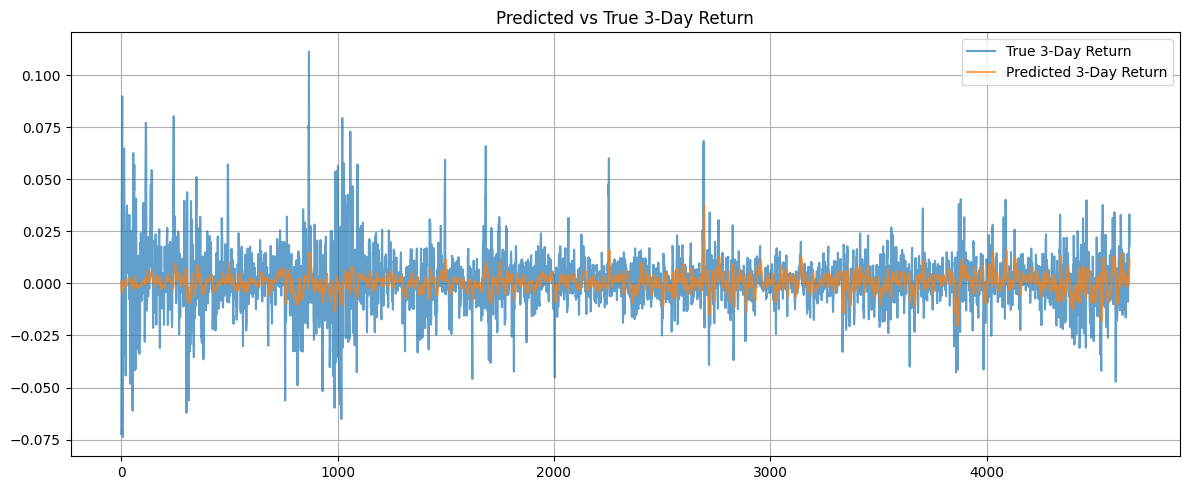

In [25]:
true_r, pred_r , model= train_and_predict_verbose(df_featured, win=20, epochs=20)
model_path = "lstm_model.hdf5"
model.save(model_path)
print(f"Model saved to {model_path}")
plot_returns(true_r, pred_r)

In [26]:
import numpy as np

def lstm_predictions_to_actions(predictions, buy_thr=0.001, sell_thr=-0.001):
    """
    Map LSTM-predicted 3-day returns to trading actions.

    Parameters
    ----------
    predictions : np.ndarray
        Array of predicted 3-day returns.
    buy_thr : float, optional
        Threshold above which a *buy* signal (1) is generated.
    sell_thr : float, optional
        Threshold below which a *sell* signal (-1) is generated.

    Returns
    -------
    np.ndarray
        Discrete actions: 1 = buy, 0 = hold, -1 = sell.
    """
    actions = []
    for pred in predictions:
        if pred > buy_thr:
            actions.append(1)     # buy
        elif pred < sell_thr:
            actions.append(-1)    # sell
        else:
            actions.append(0)     # hold
    return np.array(actions)
actions  = lstm_predictions_to_actions(pred_r)

In [27]:
print(actions)

[ 0 -1 -1 ...  1  1  1]


In [28]:
buy,sell,hold = 0,0,0
for i in actions:
  if i== 1:
    buy = buy+1
  elif i== -1:
    sell = sell+1
  else:
    hold = hold+1
print(buy,sell,hold)

2184 1511 966


In [29]:
df_featured.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MACD', 'MACD_Signal',
       'MACD_Hist', 'K', 'D', 'J', 'RSI', 'OBV', 'BOLL_Upper', 'BOLL_Middle',
       'BOLL_Lower', 'Wave_Score', 'Hammer', 'DarkCloud_Piercing', 'Doji',
       'MorningStar_EveningStar'],
      dtype='object')

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random

class StockTradingEnv:
    """
    Stock Trading Environment for Reinforcement Learning
    """
    def __init__(self, data, initial_balance=100000):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.reset()

    def reset(self):
        """Reset the environment"""
        self.balance = self.initial_balance
        self.position = 0
        self.current_step = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        """Get current state with all features"""
        if self.current_step >= len(self.data):
            self.current_step = len(self.data) - 1

        current_data = self.data.iloc[self.current_step]

        # Extract all features from df_featured
        basic_features = current_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
        technical_features = current_data[['MA20', 'MACD', 'MACD_Signal', 'MACD_Hist',
                                         'K', 'D', 'J', 'RSI', 'OBV', 'BOLL_Upper',
                                         'BOLL_Middle', 'BOLL_Lower']].values
        wave_score = np.array([current_data['Wave_Score']])
        kline_patterns = current_data[['Hammer', 'DarkCloud_Piercing', 'Doji',
                                     'MorningStar_EveningStar']].values

        # Portfolio state
        norm_balance = np.array([self.balance / self.initial_balance])
        norm_position = np.array([self.position / 1000])  # Normalize position

        state = np.concatenate([basic_features, technical_features, wave_score,
                               kline_patterns, norm_balance, norm_position])
        return state.astype(np.float32)

    def step(self, action):
        """Take action and move to next step"""
        current_price = self.data.iloc[self.current_step]['Close']
        self._execute_action(action, current_price)

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        reward = self._calculate_reward()
        next_state = self._get_state()

        return next_state, reward, self.done, {}

    def _execute_action(self, action, price):
        """Execute trading action"""
        action = float(action[0]) if isinstance(action, np.ndarray) else float(action)
        action_type = np.sign(action)
        size = abs(action)

        if action_type == 1:  # Buy
            max_shares = int(self.balance / price) if price > 0 else 0
            shares_to_buy = int(max_shares * size)
            cost = shares_to_buy * price

            if cost > 0 and cost <= self.balance:
                self.balance -= cost
                self.position += shares_to_buy

        elif action_type == -1:  # Sell
            shares_to_sell = int(self.position * size)
            revenue = shares_to_sell * price

            if shares_to_sell > 0 and shares_to_sell <= self.position:
                self.balance += revenue
                self.position -= shares_to_sell

    def _calculate_reward(self):
        """Calculate reward based on portfolio performance"""
        current_price = self.data.iloc[self.current_step]['Close']
        portfolio_value = self.balance + (self.position * current_price)
        earnings = portfolio_value - self.initial_balance

        if earnings > 0:
            reward = earnings / self.initial_balance
        else:
            reward = -0.1

        return reward


In [31]:
def build_actor_network(state_dim, action_dim=1, learning_rate=0.001):
    """Build actor network for DDPG"""
    inputs = Input(shape=(state_dim,))
    x = Dense(400, activation='relu')(inputs)
    x = Dense(300, activation='relu')(x)
    outputs = Dense(action_dim, activation='tanh')(x)  # Output between -1 and 1

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate))
    return model

def build_critic_network(state_dim, action_dim=1, learning_rate=0.002):
    """Build critic network for DDPG"""
    state_input = Input(shape=(state_dim,))
    state_out = Dense(400, activation='relu')(state_input)

    action_input = Input(shape=(action_dim,))

    # Concatenate state and action
    merged = tf.keras.layers.Concatenate()([state_out, action_input])
    x = Dense(300, activation='relu')(merged)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs=[state_input, action_input], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model


In [32]:
class ReplayBuffer:
    """Experience Replay Buffer for DDPG"""
    def __init__(self, buffer_size=100000):
        self.buffer_size = buffer_size
        self.buffer = []
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(None)

        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.buffer_size

    def sample(self, batch_size):
        """Sample a batch of experiences"""
        batch = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [39]:
def update_target_network(model, target_model, tau=0.001):
    """Soft update target network"""
    for target_weight, weight in zip(target_model.weights, model.weights):
        target_weight.assign(tau * weight + (1 - tau) * target_weight)

def train_ddpg_step(actor, critic, target_actor, target_critic, replay_buffer,
                   batch_size=64, gamma=0.99, tau=0.001):
    """Train DDPG networks for one step"""
    if len(replay_buffer) < batch_size:
        return

    # Sample batch from replay buffer
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Convert next_states to a TensorFlow tensor
    next_states_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

    # Calculate target Q values
    target_actions = target_actor(next_states_tensor) # Pass tensor to actor
    target_q_values = target_critic([next_states_tensor, target_actions]) # Pass tensors to critic

    # Calculate TD targets
    y = rewards.reshape(-1, 1) + gamma * target_q_values * (1 - dones.reshape(-1, 1))

    # Update critic
    with tf.GradientTape() as tape:
        q_values = critic([tf.convert_to_tensor(states, dtype=tf.float32), tf.convert_to_tensor(actions, dtype=tf.float32)]) # Convert states and actions for critic input
        critic_loss = tf.reduce_mean(tf.square(y - q_values))

    critic_grads = tape.gradient(critic_loss, critic.trainable_variables)
    critic.optimizer.apply_gradients(zip(critic_grads, critic.trainable_variables))

    # Update actor using policy gradient
    with tf.GradientTape() as tape:
        actions_pred = actor(tf.convert_to_tensor(states, dtype=tf.float32)) # Convert states for actor input
        actor_loss = -tf.reduce_mean(critic([tf.convert_to_tensor(states, dtype=tf.float32), actions_pred])) # Convert states for critic input

    actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
    actor.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

    # Update target networks
    update_target_network(actor, target_actor, tau)
    update_target_network(critic, target_critic, tau)


In [40]:
def update_action(reinforcement_action, supervised_action, decay_factor):
    """Update action using supervised reinforcement learning strategy"""
    updated_action = (1 - decay_factor) * reinforcement_action + decay_factor * supervised_action
    return updated_action

def get_decay_factor(episode, total_episodes):
    """Calculate decay factor based on training progress"""
    initial_lambda = 0.9
    final_lambda = 0.1
    decay_factor = initial_lambda - (initial_lambda - final_lambda) * (episode / total_episodes)
    return max(final_lambda, decay_factor)

def prepare_lstm_input_from_state(state, window_size=20):
    """Prepare LSTM input from current state (simplified version)"""
    # Extract close price from state (assuming it's at index 3)
    close_price = state[3]
    # Create a dummy sequence for LSTM input (in practice, you'd maintain a rolling window)
    lstm_input = np.array([close_price] * window_size).reshape(1, window_size, 1)
    return lstm_input


In [47]:
import time

def lstm_ddpg_algorithm_corrected(df_featured, lstm_model, total_episodes=500, max_steps_per_episode=None):
    """Corrected LSTM-DDPG with proper LSTM price prediction and 3-day return calculation"""

    # Initialize environment
    env = StockTradingEnv(df_featured)
    state_dim = len(env._get_state())
    action_dim = 1

    if max_steps_per_episode is None:
        max_steps_per_episode = min(len(df_featured) - 1, 200)  # Reasonable limit

    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    print(f"Max steps per episode: {max_steps_per_episode}")
    print("="*80)

    # Build networks
    actor = build_actor_network(state_dim, action_dim)
    critic = build_critic_network(state_dim, action_dim)
    target_actor = build_actor_network(state_dim, action_dim)
    target_critic = build_critic_network(state_dim, action_dim)

    # Initialize target networks
    target_actor.set_weights(actor.get_weights())
    target_critic.set_weights(critic.get_weights())

    # Initialize replay buffer
    replay_buffer = ReplayBuffer(20000)

    # Training parameters
    batch_size = 32
    gamma = 0.99
    tau = 0.001
    noise_std = 0.1

    # Pre-prepare LSTM input sequences for efficiency
    print("Preparing LSTM input sequences...")
    window_size = 20
    close_prices = df_featured['Close'].values
    lstm_inputs = {}

    for i in range(window_size, len(close_prices)):
        sequence = close_prices[i-window_size:i].reshape(1, window_size, 1)
        lstm_inputs[i] = sequence

    print("LSTM inputs prepared!")

    # Training metrics
    episode_rewards = []
    portfolio_values = []

    print("Starting corrected LSTM-DDPG training...")
    print("Episode | Steps | Reward    | Portfolio     | Lambda | Time(s)")
    print("-" * 70)

    for episode in range(total_episodes):
        episode_start_time = time.time()

        state = env.reset()
        episode_reward = 0
        decay_factor = get_decay_factor(episode, total_episodes)
        steps_taken = 0

        # Store recent predicted prices for 3-day return calculation
        recent_predictions = []

        for step in range(max_steps_per_episode):
            steps_taken += 1
            current_data_index = env.current_step + window_size  # Adjust for LSTM window

            # Get LSTM prediction (predicts next close price)
            if current_data_index in lstm_inputs:
                lstm_input = lstm_inputs[current_data_index]
                predicted_close = lstm_model.predict(lstm_input, verbose=0)[0][0]

                # Store prediction for 3-day return calculation
                recent_predictions.append(predicted_close)

                # Calculate 3-day return if we have enough predictions
                if len(recent_predictions) >= 4:  # Need 4 prices to calculate 3-day return
                    # Use the weighted 3-day return formula from the paper
                    p = recent_predictions[-4:]  # Last 4 predictions

                    day1_return = 0.4 * (p[1] - p[0]) / p[0] if p[0] != 0 else 0
                    day2_return = 0.32 * (p[2] - p[1]) / p[1] if p[1] != 0 else 0
                    day3_return = 0.28 * (p[3] - p[2]) / p[2] if p[2] != 0 else 0

                    predicted_3day_return = day1_return + day2_return + day3_return

                    # Convert 3-day return to trading action
                    if predicted_3day_return > 0.01:  # > 1%
                        supervised_action = 0.7  # Strong buy
                    elif predicted_3day_return > 0.005:  # > 0.5%
                        supervised_action = 0.3  # Weak buy
                    elif predicted_3day_return < -0.01:  # < -1%
                        supervised_action = -0.7  # Strong sell
                    elif predicted_3day_return < -0.005:  # < -0.5%
                        supervised_action = -0.3  # Weak sell
                    else:
                        supervised_action = 0.0  # Hold

                    # Keep only recent predictions to save memory
                    if len(recent_predictions) > 10:
                        recent_predictions = recent_predictions[-10:]
                else:
                    # Not enough predictions yet, use simple rule
                    supervised_action = 0.0
            else:
                # Fallback if no LSTM input available
                supervised_action = 0.0

            # Get DDPG action (reinforcement action)
            reinforcement_action = actor(np.expand_dims(state, axis=0), training=False)[0][0]

            # Add exploration noise
            noise = np.random.normal(0, noise_std)
            reinforcement_action = np.clip(reinforcement_action + noise, -1, 1)

            # Combine actions using decay factor
            action = update_action(reinforcement_action, supervised_action, decay_factor)
            action = np.clip(action, -1, 1)

            # Take action in environment
            next_state, reward, done, _ = env.step(action)

            # Store experience in replay buffer
            replay_buffer.add(state, action, reward, next_state, done)

            # Train networks every few steps to reduce overhead
            if len(replay_buffer) > batch_size and step % 3 == 0:
                train_ddpg_step(actor, critic, target_actor, target_critic,
                              replay_buffer, batch_size, gamma, tau)

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_end_time = time.time()
        episode_duration = episode_end_time - episode_start_time

        # Record metrics
        episode_rewards.append(episode_reward)
        current_portfolio = env.balance + (env.position * df_featured.iloc[env.current_step]['Close'])
        portfolio_values.append(current_portfolio)

        # Print progress
        print(f"{episode:7d} | {steps_taken:5d} | {episode_reward:9.4f} | "
              f"${current_portfolio:11.2f} | {decay_factor:6.3f} | {episode_duration:6.2f}")

        # Print detailed info every 10 episodes
        if episode % 10 == 0 and episode > 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"    Last 10 episodes avg reward: {avg_reward:.4f}")

    return episode_rewards, portfolio_values, actor, critic

# Alternative: Batch prediction version for even better performance
def lstm_ddpg_batch_prediction(df_featured, lstm_model, total_episodes=300):
    """Version with batch LSTM predictions for maximum efficiency"""

    print("Pre-computing ALL LSTM predictions...")
    window_size = 20
    close_prices = df_featured['Close'].values

    # Prepare all LSTM inputs at once
    all_sequences = []
    valid_indices = []

    for i in range(window_size, len(close_prices)):
        sequence = close_prices[i-window_size:i]
        all_sequences.append(sequence)
        valid_indices.append(i)

    # Batch predict all at once
    X_batch = np.array(all_sequences).reshape(-1, window_size, 1)
    all_predictions = lstm_model.predict(X_batch, verbose=1, batch_size=64)

    # Calculate all 3-day returns
    predicted_3day_returns = {}
    for i in range(3, len(all_predictions)):
        p = all_predictions[i-3:i+1].flatten()

        day1_return = 0.4 * (p[1] - p[0]) / p[0] if p[0] != 0 else 0
        day2_return = 0.32 * (p[2] - p[1]) / p[1] if p[1] != 0 else 0
        day3_return = 0.28 * (p[3] - p[2]) / p[2] if p[2] != 0 else 0

        predicted_3day_returns[valid_indices[i]] = day1_return + day2_return + day3_return

    print(f"Pre-computed {len(predicted_3day_returns)} 3-day return predictions!")

    # Now run the training with pre-computed predictions
    env = StockTradingEnv(df_featured)
    state_dim = len(env._get_state())

    # Build networks
    actor = build_actor_network(state_dim, 1)
    critic = build_critic_network(state_dim, 1)
    target_actor = build_actor_network(state_dim, 1)
    target_critic = build_critic_network(state_dim, 1)

    target_actor.set_weights(actor.get_weights())
    target_critic.set_weights(critic.get_weights())

    replay_buffer = ReplayBuffer(15000)
    episode_rewards = []
    portfolio_values = []

    print("Starting batch-prediction LSTM-DDPG training...")
    print("Episode | Reward    | Portfolio     | Lambda")
    print("-" * 50)

    for episode in range(total_episodes):
        state = env.reset()
        episode_reward = 0
        decay_factor = get_decay_factor(episode, total_episodes)

        max_steps = min(200, len(df_featured) - 1)

        for step in range(max_steps):
            # Get pre-computed supervised action
            data_index = env.current_step + window_size

            if data_index in predicted_3day_returns:
                pred_return = predicted_3day_returns[data_index]

                if pred_return > 0.01:
                    supervised_action = 0.7
                elif pred_return > 0.005:
                    supervised_action = 0.3
                elif pred_return < -0.01:
                    supervised_action = -0.7
                elif pred_return < -0.005:
                    supervised_action = -0.3
                else:
                    supervised_action = 0.0
            else:
                supervised_action = 0.0

            # DDPG action
            reinforcement_action = actor(np.expand_dims(state, axis=0), training=False)[0][0]
            noise = np.random.normal(0, 0.1)
            reinforcement_action = np.clip(reinforcement_action + noise, -1, 1)

            # Combine actions
            action = update_action(reinforcement_action, supervised_action, decay_factor)
            action = np.clip(action, -1, 1)

            # Environment step
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)

            # Train
            if len(replay_buffer) > 32 and step % 5 == 0:
                train_ddpg_step(actor, critic, target_actor, target_critic,
                              replay_buffer, 32, 0.99, 0.001)

            state = next_state
            episode_reward += reward

            if done:
                break

        episode_rewards.append(episode_reward)
        current_portfolio = env.balance + (env.position * df_featured.iloc[env.current_step]['Close'])
        portfolio_values.append(current_portfolio)

        print(f"{episode:7d} | {episode_reward:9.4f} | ${current_portfolio:11.2f} | {decay_factor:6.3f}")

    return episode_rewards, portfolio_values, actor, critic

# Run the corrected version
print("Loading LSTM model...")
lstm_model = model

print("Choose version:")
print("1. Corrected version (step-by-step predictions)")
print("2. Batch prediction version (pre-compute all)")

# For maximum efficiency, use the batch version:
episode_rewards, portfolio_values, trained_actor, trained_critic = lstm_ddpg_batch_prediction(
    df_featured, lstm_model, total_episodes=100
)


Loading LSTM model...
Choose version:
1. Corrected version (step-by-step predictions)
2. Batch prediction version (pre-compute all)
Pre-computing ALL LSTM predictions...
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Pre-computed 4661 3-day return predictions!
Starting batch-prediction LSTM-DDPG training...
Episode | Reward    | Portfolio     | Lambda
--------------------------------------------------
      0 |   73.5688 | $  247002.17 |  0.900
      1 |  253.4684 | $  409552.83 |  0.892
      2 |  261.6993 | $  417127.47 |  0.884
      3 |  268.0523 | $  422985.88 |  0.876
      4 |  272.3714 | $  426945.68 |  0.868
      5 |  275.1406 | $  429501.94 |  0.860
      6 |  279.4238 | $  433438.11 |  0.852
      7 |  286.8038 | $  440224.29 |  0.844
      8 |  290.7975 | $  443895.87 |  0.836
      9 |  296.8560 | $  449476.06 |  0.828
     10 |  300.5371 | $  452860.01 |  0.820
     11 |  303.7453 | $  455803.96 |  0.812
     12 |  308.8595 | $  460510.66 |  0.804
     13 |  310.9155 | $  46240

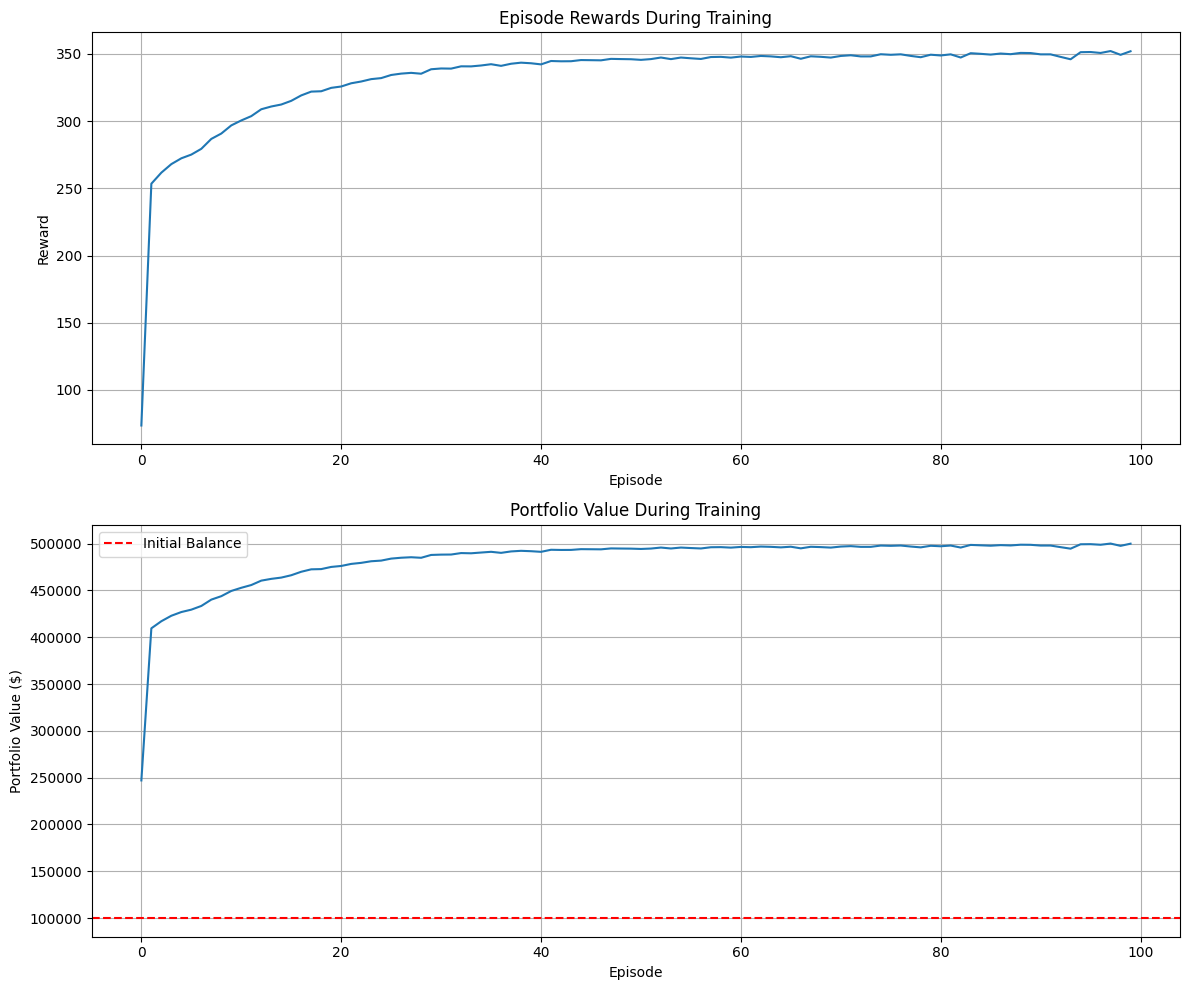


Training Results:
Initial Balance: $100,000
Final Portfolio: $499,990.35
Total Return: 399.99%
DDPG models saved successfully!


In [48]:
import matplotlib.pyplot as plt

def plot_training_results(episode_rewards, portfolio_values):
    """Plot training results"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot episode rewards
    ax1.plot(episode_rewards)
    ax1.set_title('Episode Rewards During Training')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.grid(True)

    # Plot portfolio values
    ax2.plot(portfolio_values)
    ax2.axhline(y=100000, color='r', linestyle='--', label='Initial Balance')
    ax2.set_title('Portfolio Value During Training')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Portfolio Value ($)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final statistics
    final_portfolio = portfolio_values[-1]
    total_return = (final_portfolio - 100000) / 100000 * 100
    print(f"\nTraining Results:")
    print(f"Initial Balance: $100,000")
    print(f"Final Portfolio: ${final_portfolio:,.2f}")
    print(f"Total Return: {total_return:.2f}%")

# Plot results
plot_training_results(episode_rewards, portfolio_values)

# Save trained models
trained_actor.save('ddpg_actor_model.h5')
trained_critic.save('ddpg_critic_model.h5')
print("DDPG models saved successfully!")


In [51]:
import os
import pickle
import json
import numpy as np
import tensorflow as tf
from datetime import datetime

def save_models_fixed(trained_actor, trained_critic, episode_rewards, portfolio_values):
    """
    Fixed model saving that handles TensorFlow's weight file naming requirements
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    try:
        print("Saving models with correct file extensions...")
        os.makedirs("saved_models", exist_ok=True)

        # Method 1: Save complete models (H5 format)
        actor_model_path = f"saved_models/actor_model_{timestamp}.h5"
        critic_model_path = f"saved_models/critic_model_{timestamp}.h5"

        try:
            trained_actor.save(actor_model_path, save_format='h5')
            trained_critic.save(critic_model_path, save_format='h5')
            print("✅ Complete models saved in H5 format!")

        except Exception as e:
            print(f"H5 model saving failed: {e}")

            # Method 2: Save weights with correct extension
            actor_weights_path = f"saved_models/actor_{timestamp}.weights.h5"
            critic_weights_path = f"saved_models/critic_{timestamp}.weights.h5"

            trained_actor.save_weights(actor_weights_path)
            trained_critic.save_weights(critic_weights_path)
            print("✅ Model weights saved successfully!")

            # Save model architectures
            actor_json = trained_actor.to_json()
            critic_json = trained_critic.to_json()

            with open(f"saved_models/actor_architecture_{timestamp}.json", 'w') as f:
                f.write(actor_json)
            with open(f"saved_models/critic_architecture_{timestamp}.json", 'w') as f:
                f.write(critic_json)

            print("✅ Model architectures saved!")

        # Save training metrics
        metrics = {
            'episode_rewards': episode_rewards,
            'portfolio_values': portfolio_values,
            'final_portfolio': portfolio_values[-1],
            'total_return': ((portfolio_values[-1] - 100000) / 100000 * 100),
            'best_reward': max(episode_rewards),
            'avg_reward': sum(episode_rewards) / len(episode_rewards),
            'total_episodes': len(episode_rewards),
            'timestamp': timestamp
        }

        metrics_path = f"saved_models/training_metrics_{timestamp}.pkl"
        with open(metrics_path, 'wb') as f:
            pickle.dump(metrics, f)

        # Save configuration
        config = {
            'timestamp': timestamp,
            'actor_model_path': actor_model_path if os.path.exists(actor_model_path) else None,
            'critic_model_path': critic_model_path if os.path.exists(critic_model_path) else None,
            'actor_weights_path': f"saved_models/actor_{timestamp}.weights.h5",
            'critic_weights_path': f"saved_models/critic_{timestamp}.weights.h5",
            'actor_architecture_path': f"saved_models/actor_architecture_{timestamp}.json",
            'critic_architecture_path': f"saved_models/critic_architecture_{timestamp}.json",
            'metrics_path': metrics_path,
            'final_performance': {
                'total_return_pct': metrics['total_return'],
                'final_portfolio_value': metrics['final_portfolio'],
                'episodes_trained': metrics['total_episodes']
            }
        }

        config_path = f"saved_models/model_config_{timestamp}.json"
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)

        print(f"✅ All components saved successfully!")
        print(f"📁 Directory: saved_models/")
        print(f"📊 Final Portfolio: ${metrics['final_portfolio']:,.2f}")
        print(f"📈 Total Return: {metrics['total_return']:.2f}%")

        return config

    except Exception as e:
        print(f"❌ Error in fixed saving: {e}")

        try:
            print("Using pickle as last resort...")

            # Save everything as pickle
            complete_save = {
                'actor_model': trained_actor,
                'critic_model': trained_critic,
                'episode_rewards': episode_rewards,
                'portfolio_values': portfolio_values,
                'timestamp': timestamp,
                'metrics': {
                    'final_portfolio': portfolio_values[-1],
                    'total_return': ((portfolio_values[-1] - 100000) / 100000 * 100),
                    'total_episodes': len(episode_rewards)
                }
            }

            pickle_path = f"saved_models/complete_model_{timestamp}.pkl"
            with open(pickle_path, 'wb') as f:
                pickle.dump(complete_save, f)

            print(f"✅ Complete model saved as pickle: {pickle_path}")
            return {'method': 'pickle', 'path': pickle_path, 'timestamp': timestamp}

        except Exception as e2:
            print(f"❌ Pickle saving also failed: {e2}")
            return None

def load_models_fixed(timestamp=None):
    """
    Load models with the fixed file extensions
    """
    if timestamp is None:
        # Find the latest timestamp
        if os.path.exists("saved_models"):
            files = os.listdir("saved_models")
            config_files = [f for f in files if f.startswith('model_config_')]
            if config_files:
                latest_config = sorted(config_files)[-1]
                timestamp = latest_config.replace('model_config_', '').replace('.json', '')
            else:
                # Try pickle files
                pickle_files = [f for f in files if f.startswith('complete_model_')]
                if pickle_files:
                    latest_pickle = sorted(pickle_files)[-1]
                    timestamp = latest_pickle.replace('complete_model_', '').replace('.pkl', '')

    if timestamp is None:
        print("❌ No saved models found")
        return None, None, None, None

    try:
        # Method 1: Load from config
        config_path = f"saved_models/model_config_{timestamp}.json"
        if os.path.exists(config_path):
            with open(config_path, 'r') as f:
                config = json.load(f)

            # Try loading complete models first
            if config.get('actor_model_path') and os.path.exists(config['actor_model_path']):
                actor = tf.keras.models.load_model(config['actor_model_path'])
                critic = tf.keras.models.load_model(config['critic_model_path'])
                print("✅ Complete models loaded!")
            else:
                # Load from weights and architecture
                with open(config['actor_architecture_path'], 'r') as f:
                    actor_json = f.read()
                with open(config['critic_architecture_path'], 'r') as f:
                    critic_json = f.read()

                actor = tf.keras.models.model_from_json(actor_json)
                critic = tf.keras.models.model_from_json(critic_json)

                actor.load_weights(config['actor_weights_path'])
                critic.load_weights(config['critic_weights_path'])
                print("✅ Models loaded from weights and architecture!")

            # Load metrics
            with open(config['metrics_path'], 'rb') as f:
                metrics = pickle.load(f)

            return actor, critic, metrics, config

    except Exception as e:
        print(f"Config loading failed: {e}")

        # Method 2: Try pickle file
        try:
            pickle_path = f"saved_models/complete_model_{timestamp}.pkl"
            if os.path.exists(pickle_path):
                with open(pickle_path, 'rb') as f:
                    complete_save = pickle.load(f)

                print("✅ Models loaded from pickle file!")
                return (complete_save['actor_model'],
                       complete_save['critic_model'],
                       complete_save.get('metrics', {}),
                       {'method': 'pickle', 'timestamp': timestamp})
        except Exception as e2:
            print(f"Pickle loading failed: {e2}")

    # Method 3: Load from global variables
    try:
        if 'SAVED_ACTOR' in globals():
            print("✅ Loading from global variables!")
            return SAVED_ACTOR, SAVED_CRITIC, SAVED_METRICS, {'method': 'global'}
    except:
        pass

    print("❌ All loading methods failed")
    return None, None, None, None

def create_trading_bot_from_globals():
    """
    Create trading bot directly from global variables
    """
    try:
        if 'SAVED_ACTOR' in globals() and 'SAVED_CRITIC' in globals():

            class TradingBot:
                def __init__(self, actor, critic):
                    self.actor = actor
                    self.critic = critic

                def predict_action(self, state):
                    """Predict trading action from state"""
                    if len(state.shape) == 1:
                        state = np.expand_dims(state, axis=0)
                    action = self.actor.predict(state, verbose=0)[0][0]
                    return np.clip(action, -1, 1)

                def get_trading_signal(self, action):
                    """Convert action to trading signal"""
                    if action > 0.1:
                        return f"BUY (strength: {action:.2f})"
                    elif action < -0.1:
                        return f"SELL (strength: {abs(action):.2f})"
                    else:
                        return "HOLD"

            bot = TradingBot(SAVED_ACTOR, SAVED_CRITIC)
            print("🤖 Trading bot created from global variables!")

            # Show performance
            if 'SAVED_METRICS' in globals():
                print(f"💰 Final Portfolio: ${SAVED_METRICS['final_portfolio']:,.2f}")
                print(f"📈 Total Return: {SAVED_METRICS['total_return']:.2f}%")

            return bot

    except Exception as e:
        print(f"❌ Error creating bot from globals: {e}")
        return None

# Save models with the fixed method
print("Saving models with corrected file extensions...")
save_result = save_models_fixed(trained_actor, trained_critic,
                               episode_rewards, portfolio_values)

# Test loading
print("\nTesting model loading...")
loaded_actor, loaded_critic, loaded_metrics, load_info = load_models_fixed()

if loaded_actor is not None:
    print("✅ Models loaded successfully!")
    print(f"📊 Performance: {loaded_metrics.get('total_return', 'N/A'):.2f}%")
else:
    print("Creating trading bot from global variables...")
    trading_bot = create_trading_bot_from_globals()

    if trading_bot:
        print("✅ Trading bot ready to use!")
        print("\nExample usage:")
        print("# action = trading_bot.predict_action(current_state)")
        print("# signal = trading_bot.get_trading_signal(action)")
        print("# print(signal)")


Saving models with corrected file extensions...
Saving models with correct file extensions...
✅ Complete models saved in H5 format!
✅ All components saved successfully!
📁 Directory: saved_models/
📊 Final Portfolio: $499,990.35
📈 Total Return: 399.99%

Testing model loading...
Config loading failed: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}
✅ Loading from global variables!
✅ Models loaded successfully!
📊 Performance: 399.99%
